### Professor: Cleison Silva

### Alunos:
>> ####            Oséias Dias de Farias
>> ####            Thalia Barroso
>> ####            Andrez Miller

# **Sistema de Controle em Malha Fechada**

<p align = 'justify' > O diagrama de blocos abaixo, ilustra o esquema básico de sistemas de controle em malha fechada com realimentação negativa. No esquema, destaca-se $4$ sinais principais:  o sinal de referência, o sinal de erro de controle, o sinal de controle e o sinal de saída. </p>

Tem-se também, dois sistema em destaque, o **processo**, representando a dinâmica a ser controlada e o **controlador**. </p>

# **Projeto Controlador Proporcional**

Considera-se a Função de Transferência de Malha Aberta ("Processo") do sistema Motor-Gerador sendo de primeira ordem: 

$$ G(s) = \frac{K_m}{\tau s + 1} \tag{1}$$


Admita que $G_c(s)$ representa a função de transferência do controlador. Em malha fechada, representado por, $H(s)$, é 

$$ H(s) = \frac{G_c(s) G(s)}{1 + G_c(s) G(s)} \tag{2}$$

Considerando $G_c(s) = K_p$, a Função de Transferência de Malha Fechada, com controlador proporcional, é:

$$ H(s) = \frac{K_p G(s)}{1 + K_p G(s)} \tag{3}$$


Substituindo $G(s)$ em $H(s)$, ou seja, (1) em (2): 
$$ H(s) = \dfrac{ \dfrac{K_p K_m}{1 + K_p K_m} }{ \dfrac{\tau}{1 + K_p K_m}s +1 } \tag{4}$$

Observa-se que, tanto o ganho quanto a constante de tempo do sistema em malha fechada são funções do ganho proporcional do controlador. Isso permite projetar o ganho do controlador ($K_p$) de tal forma que o sistema em MF responda a fim de atender critérios de desempenho especificados. 



[A biblioteca em python de sistemas de controle pode ser acessa aqui!](https://python-control.readthedocs.io/en/latest/intro.html)

Por exemplo, é possível projetar o ganho do controlador ($K_p$) com o objetivo de tornar a resposta do sistema em MF "mais" rápida. No entanto, considere as seguintes observações:

1. Resposta mais rápida, implica que a constante de tempo do sistema em MF deve ser menor do que a constante de tempo em MA. O quanto menor ?

2. O $K_p$ também altera o ganho DC do sistema em MF. 

3. O controlador proporcional não altera o tipo do sistema. Se o sistema em MA for do tipo $0$, o sistema em malha fechada com  controlador proporcional permanence sendo do tipo ZERO. Explique.

4. O erro em regime permanente para sistema do Tipo $0$, com controlador proporcional, é não nulo. Explique. 


Para fins de simulação, vamos considerar os seguintes parâmetros para o sistema em MA: $K_m = 0.18874$ e $\tau = 0.1675$.

Desse forma, vamos adotar como especificações de desempenho de MF, os seguites critérios:

1. Constante de tempo de MF ser $70\%$ da constante de malha aberta.  $$\tau_{MF} = 0,7 \tau $$

Substituindo em $(4)$, tem-se: 

$$ \frac{7}{10} = \frac{1}{1 + K_p K_m}$$

$$ K_p = \frac{ \big(\frac{10}{7} - 1 \big )}{K_m} = 2.2706  $$

In [1]:
km = 0.18874
tau = 0.1675

Kp = (10/7 - 1)/km
print(f"\n{Kp}")


2.2706974068635617


# **Simulação do Sistema em Malha Aberta**

In [2]:
# !pip install control -q

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import control as ct
import scipy.signal as sg
from control.matlab import *

%config InlineBackend.figure_format='retina'

In [4]:
dados = pd.read_csv("../dados/piano_Onda_Quadrada_Exemplo.csv", header = None).values
dados

array([[ 0.        ,  0.02      ,  0.04      , ..., 14.94      ,
        14.96      , 14.98      ],
       [ 8.        ,  8.        ,  8.        , ...,  8.        ,
         8.        ,  8.        ],
       [ 0.        ,  0.        ,  0.        , ...,  2.57      ,
         2.57      ,  2.57      ],
       [ 0.02300167,  0.02000022,  0.020998  , ...,  0.03238726,
         0.03123212,  0.03124857]])

In [5]:
# Dados do ensaio
tempo = dados[0, :]
sinal_entrada  = dados[1, :]
sinal_saida = dados[2, :]
toc = dados[3, :]

# Define janela que despreza os primeiros instantes do ensaio
janela = (tempo>2) & (tempo<14)

# Obtendo o nível DC da entrada
nivel_dc_entrada = np.mean(sinal_entrada[janela])

# Obtendo o nível DC da saída
nivel_dc_saida = np.mean(sinal_saida[janela])

# Remove Nivel DC da Entrada e da Saída
r = sinal_entrada - nivel_dc_entrada
y = sinal_saida - nivel_dc_saida


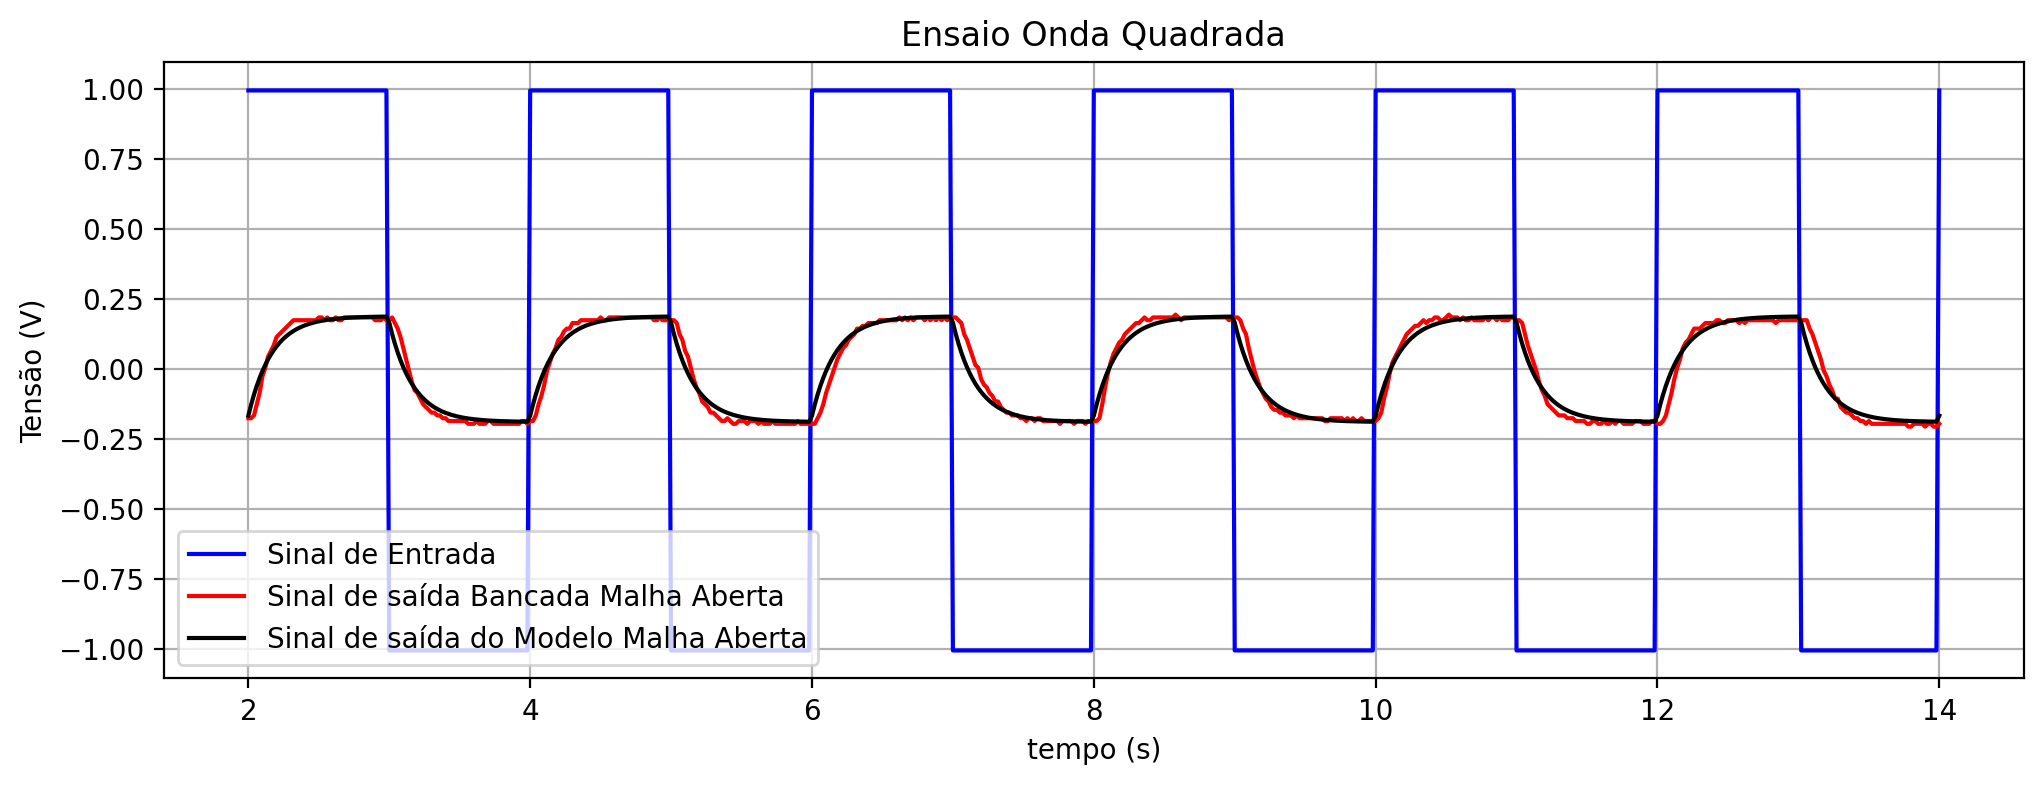

In [6]:
num = [km]
den = [tau, 1.]

Gs = ct.tf(num, den)
_, saida_modelo_com_dc = ct.forced_response(Gs, T=tempo, U=sinal_entrada)

# Tirando a média para subtrair o Nível DC do modelo
nivel_dc_modelo = np.mean(saida_modelo_com_dc[janela])
saida_sem_dc_modelo = saida_modelo_com_dc[janela] - nivel_dc_modelo

# Plotagem dos gráficos dos sinais de entrada e saída sem nível DC
plt.figure(figsize=(12, 4))
plt.plot(tempo[janela],r[janela], c = 'b', label = "Sinal de Entrada")
plt.plot(tempo[janela], y[janela], 'r', label = "Sinal de saída Bancada Malha Aberta")
plt.plot(tempo[janela], saida_sem_dc_modelo, 'k', label = "Sinal de saída do Modelo Malha Aberta")

plt. title('Ensaio Onda Quadrada')
plt.ylabel('Tensão (V)')
plt.xlabel('tempo (s)')
plt.legend()
plt.grid()
plt.show()


# **Simulação do Sistema em Malha Fechada**

Sistema em Malha Aberta:
 
   0.1887
------------
0.1675 s + 1

Sistema em Malha Fechada:
 
     0.4044
----------------
0.1675 s + 1.404



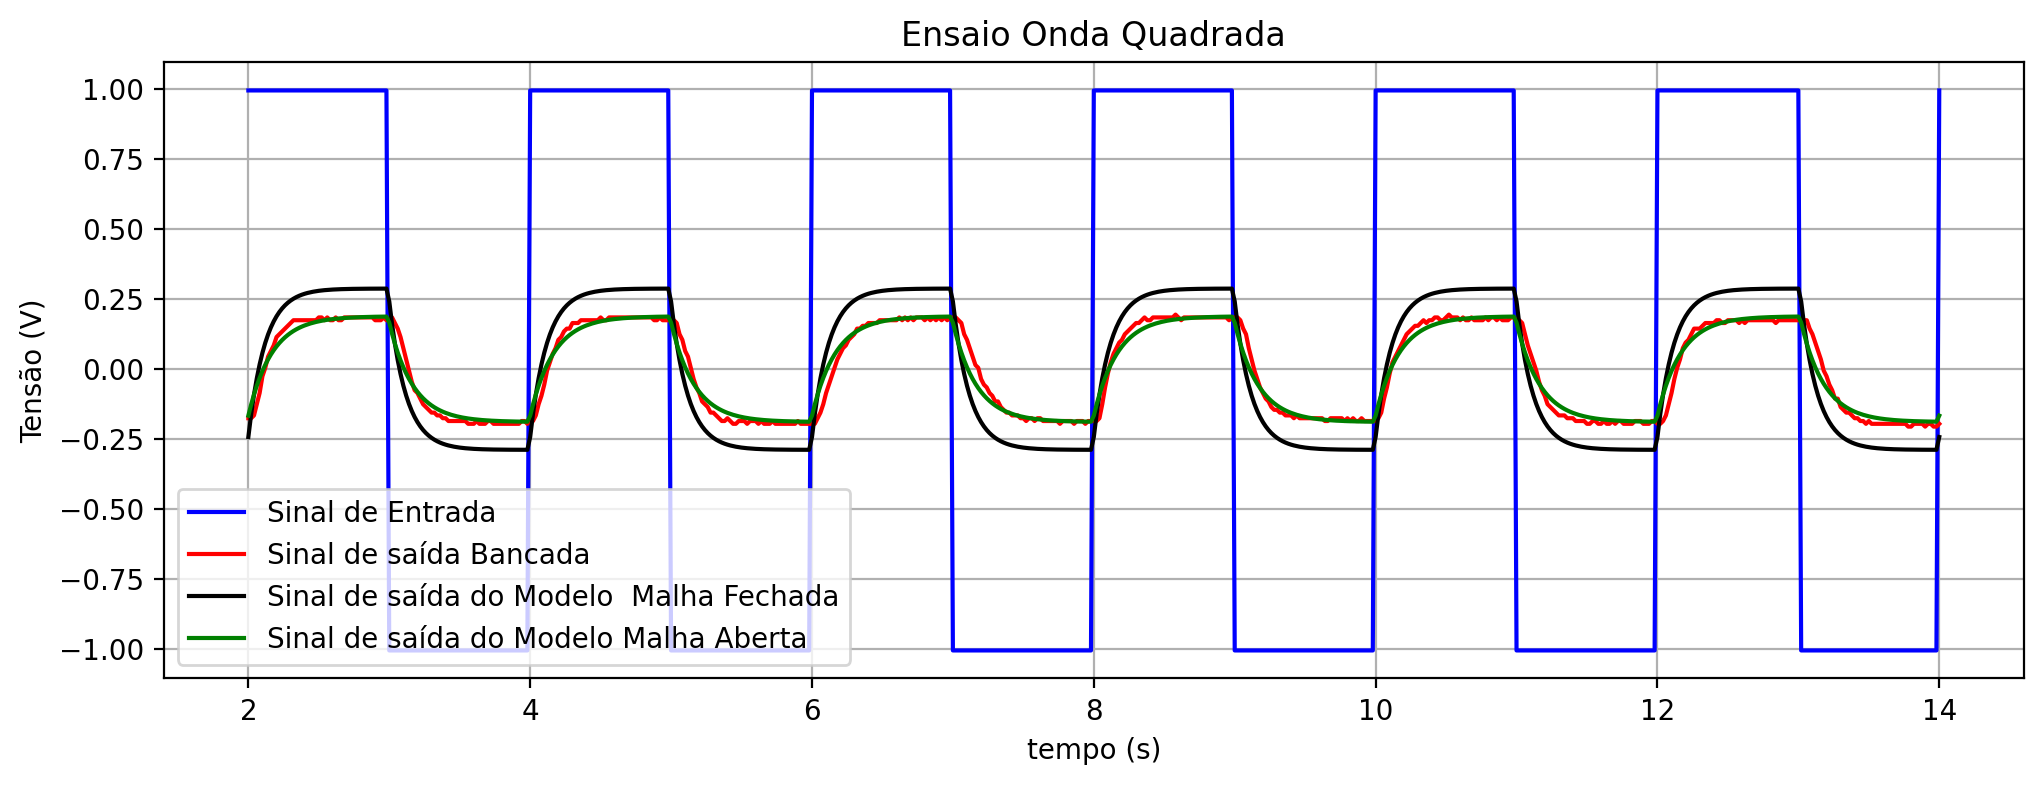

In [7]:
def sistema_mf_controleP(Kp):

    # Define o sinal de entrada e sinal de referência
    # Sistema em Malha Aberta
    print("Sistema em Malha Aberta:\n", Gs)

    # Controlador Propocional
    Gc = Kp

    # Sistema em Malha Fechada - com Controlador Proporcional
    Gs_serie = ct.series(Gs, Gc)
    Gs_serie
    Gs_malha_fechada = ct.feedback(Gs_serie, 1, -1)
    Gs_malha_fechada

    print("Sistema em Malha Fechada:\n", Gs_malha_fechada)

    # Simulação do Sistema em Malha Fechada para Onda Quadrada
    _, saida_modelo_mf = ct.forced_response(Gs_malha_fechada, T=tempo, U=sinal_entrada)

    # Simulação do Sistema em Malha Fechada para Onda Quadrada
    # Tirando a média para subtrair o Nível DC do modelo
    nivel_dc_modelo_mf = np.mean(saida_modelo_mf[janela])
    saida_sem_dc_modelo_mf = saida_modelo_mf[janela] - nivel_dc_modelo_mf

    # Plotagem dos gráficos dos sinais de entrada e saída sem nível DC
    plt.figure(figsize=(12, 4))
    plt.plot(tempo[janela],r[janela], c = 'b', label = "Sinal de Entrada")
    plt.plot(tempo[janela], y[janela], 'r', label = "Sinal de saída Bancada")
    plt.plot(tempo[janela], saida_sem_dc_modelo_mf, 'k', label = "Sinal de saída do Modelo  Malha Fechada")
    plt.plot(tempo[janela], saida_sem_dc_modelo, 'g', label = "Sinal de saída do Modelo Malha Aberta")

    plt. title('Ensaio Onda Quadrada')
    plt.ylabel('Tensão (V)')
    plt.xlabel('tempo (s)')
    plt.legend()
    plt.grid()
    plt.show()

# Simulação com ganho do controlador P igual a 15/7
sistema_mf_controleP(Kp = 15/7.)

Sistema em Malha Aberta:
 
   0.1887
------------
0.1675 s + 1

Sistema em Malha Fechada:
 
     1.887
----------------
0.1675 s + 2.887



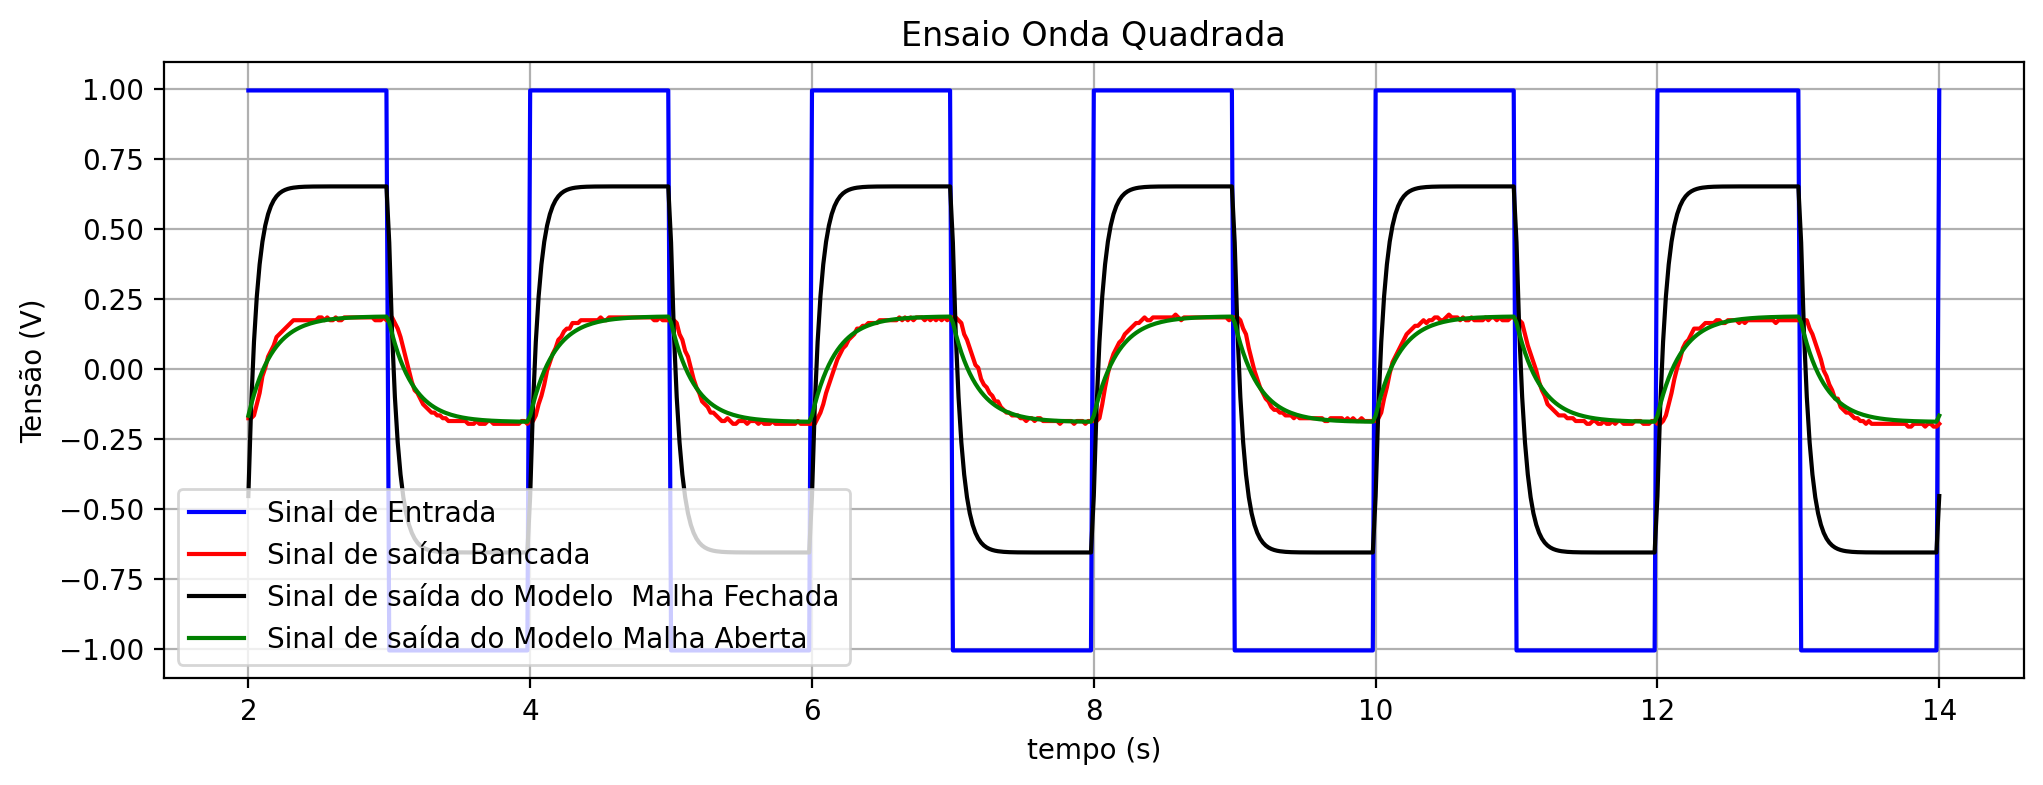

In [8]:
# Simulação com ganho do controlador P igual a 15/1.5
sistema_mf_controleP(Kp = 15/1.5)

# **Exercício de Fixação**

Analise a resposta do sistema em malha fechada com o controlador proporcionale responda:

1. A resposta do sistema em malha fechada é mais rápida do que a resposta em malha aberta?  Explique. 
2. A medida que o ganho $K_p$ assume valores elevados, o polo de malha fechada se afasta do eixo imaginário, no plano complexo. Verdadeiro ou Falso? Explique.
3. O erro em regime permanente está elevado. Sem substituir o tipo de controlador, o que poderia ser alterado (e como) a  fim de reduzir o erro em regime permanente?  Explique quais conseguências são esperadas com essa medida.


# **Sinal de Controle**

Em simulação, pode-se admitir valores elevados para o ganho do controlador, com a finalidade de reduzir o erro em regime permanente. No entanto, quanto maior o valor de $K_p$, maior será a magnitude do sinal de controle. 

Deve-se lembrar que a bancada é alimentada por uma fonte de tensão finita. Logo a magnitude do sinal de controle não deve ser superior a tensão de alimentação da bancada Motor-Gerador.

Para simular o sistema em MF e obter na saída o sinal de controle, deve-se criar um sistema com essa finalidade.

A função *feedback (sys1, sys2, sign = -1)* admite:

1.  O *sys1* função de transferencia de Malha Direta; 
2.  O *sys2* função de transferencia de Realimentação; 
3.  O *sign* sinal da realimentação, para controle deve ser *sign = -1*.


Sendo assim, faz-se: 

1. *sys1* igual a $G_c (s)$
2. *sys2* igual a $G(s)$



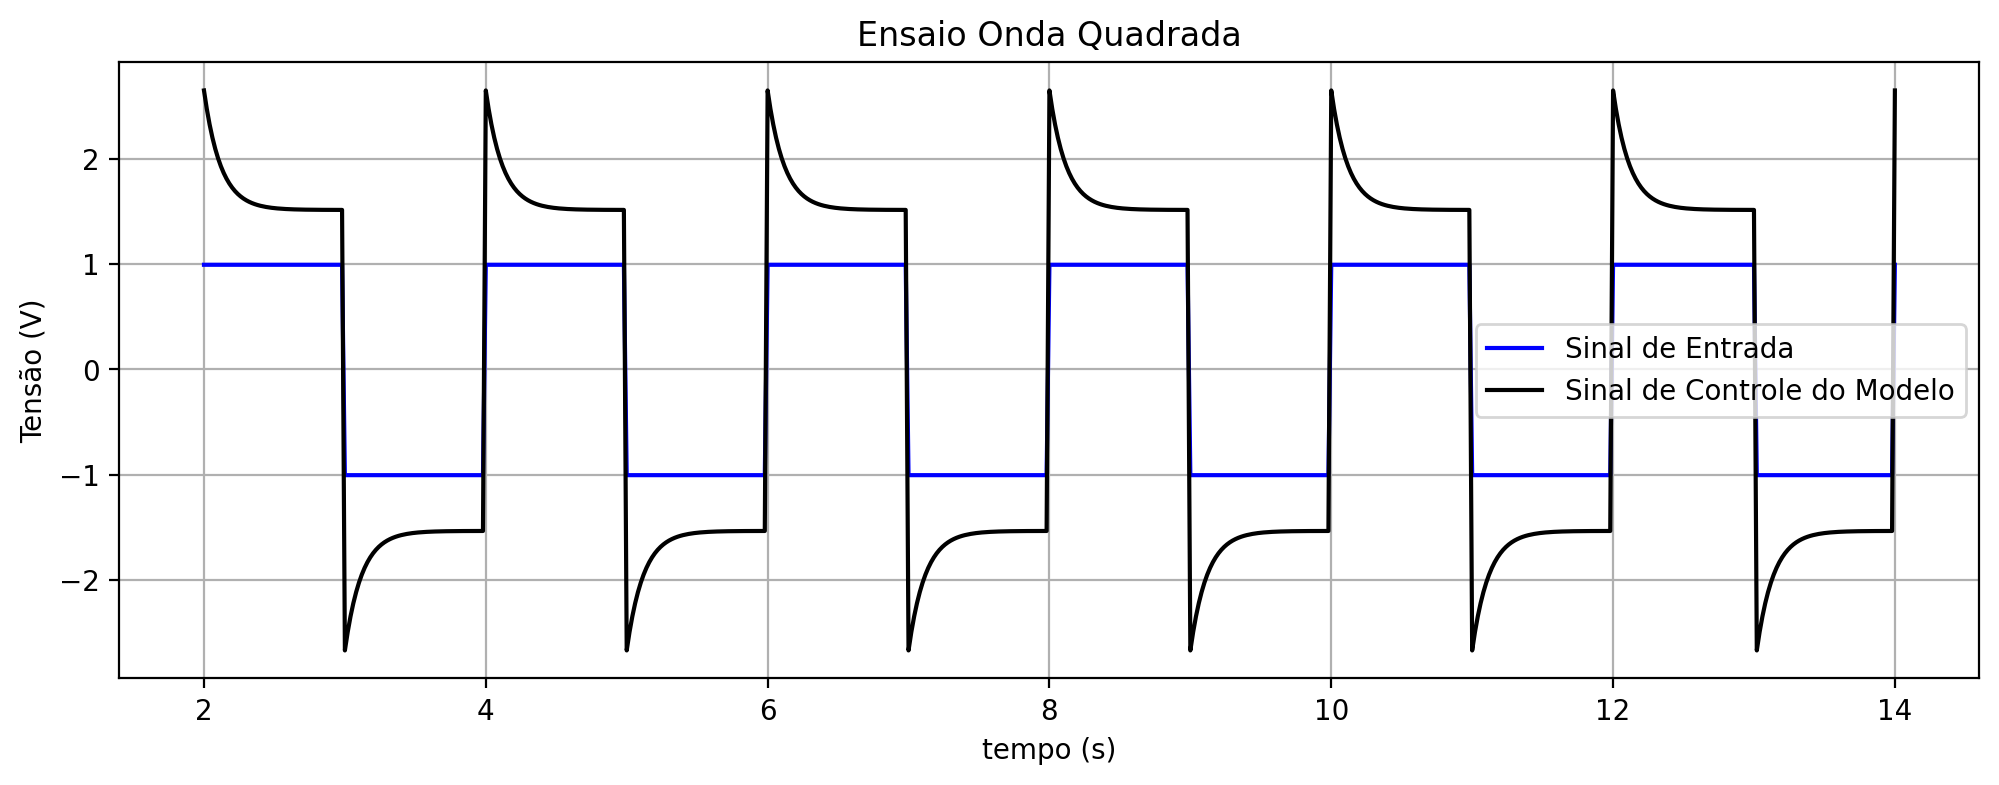

In [9]:
def sinal_controleP(Kp):
    Gc = Kp
    # Sistema para Obter Sinal de Controle
    Us = ct.feedback(Gc, Gs, -1)

    # Simulação para obter o Sinal de Controle
    _, saida_modelo = ct.forced_response(Us, T=tempo, U=sinal_entrada)

    # Simulação do Sistema em Malha Fechada para Onda Quadrada

    # Tirando a média para subtrair o Nível DC do modelo
    nivel_dc_modelo_ct = np.mean(saida_modelo[janela])
    saida_sem_dc_modelo_ct = saida_modelo[janela] - nivel_dc_modelo_ct

    # Plotagem dos gráficos dos sinais de entrada e saída sem nível DC
    plt.figure(figsize=(12, 4))
    plt.plot(tempo[janela], r[janela], c = 'b', label = "Sinal de Entrada")
    plt.plot(tempo[janela], saida_sem_dc_modelo_ct, 'k', label = "Sinal de Controle do Modelo")

    plt. title('Ensaio Onda Quadrada')
    plt.ylabel('Tensão (V)')
    plt.xlabel('tempo (s)')
    plt.legend()
    plt.grid()
    plt.show()

# Sinal de controle com controlador proporcional igual a Kp = 15/7.
sinal_controleP(Kp = 15/7.)


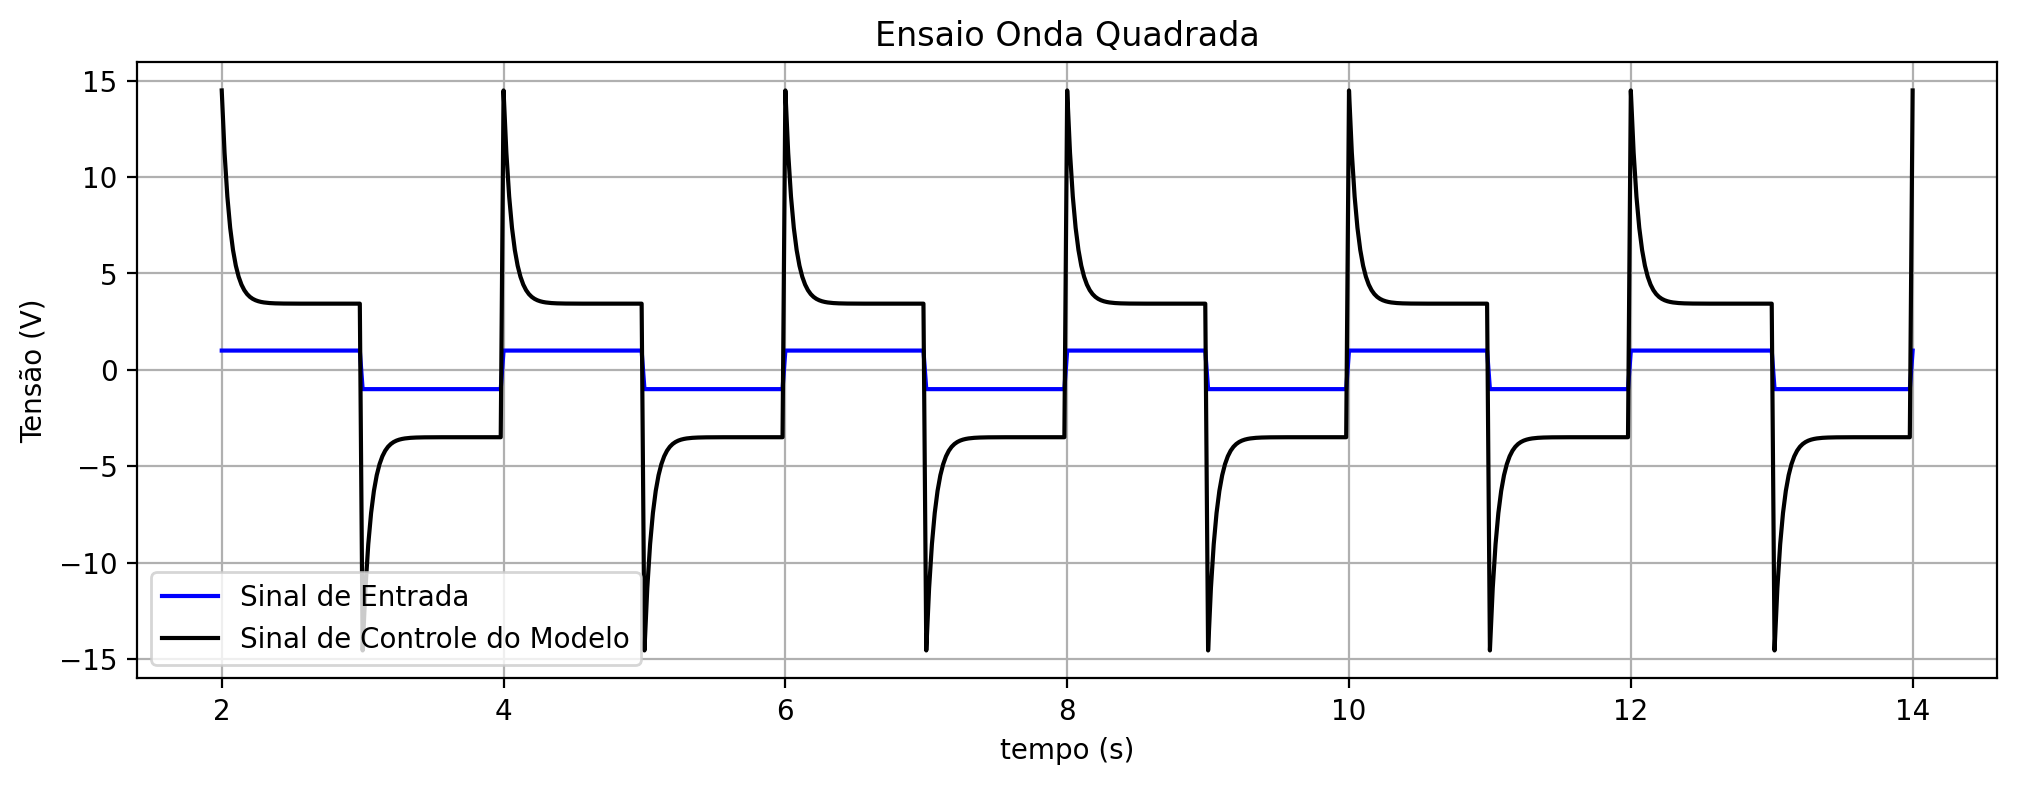

In [10]:
# Sinal de controle com controlador proporcional igual a Kp = 15/1.5
sinal_controleP(Kp = 15/1.5)

# **Lugar Geométrico das Raízes - LGR**

Considere $G(s)$ a função de transferência de malha direta em cascata com o controlador $K$, com realimentação unitária e negativa. Em malha fechada, tem-se:

$$ H(s) = \frac{K G(s)}{1+ K G(s)}$$

O LGR corresponde a todos os pontos no plano complexo que as raízes do polinômio do denominador de $H(s)$ pode assumir quando o ganho $K$ varia de zero a infinito. Sendo assim, tem-se:

$$ 1 + K G(s) = 0. \tag{A}$$

Para valores de $K$ positivos, a equação (A) impõe duas restrições sobre o LGR, são elas:

1. $\angle{G(s)} = (2\ell +1)180^{0}$, para $\ell = 0, \pm 1, \pm 2, ...$ 

2. O ganho $K = \frac{1}{| G(s) |}$ 



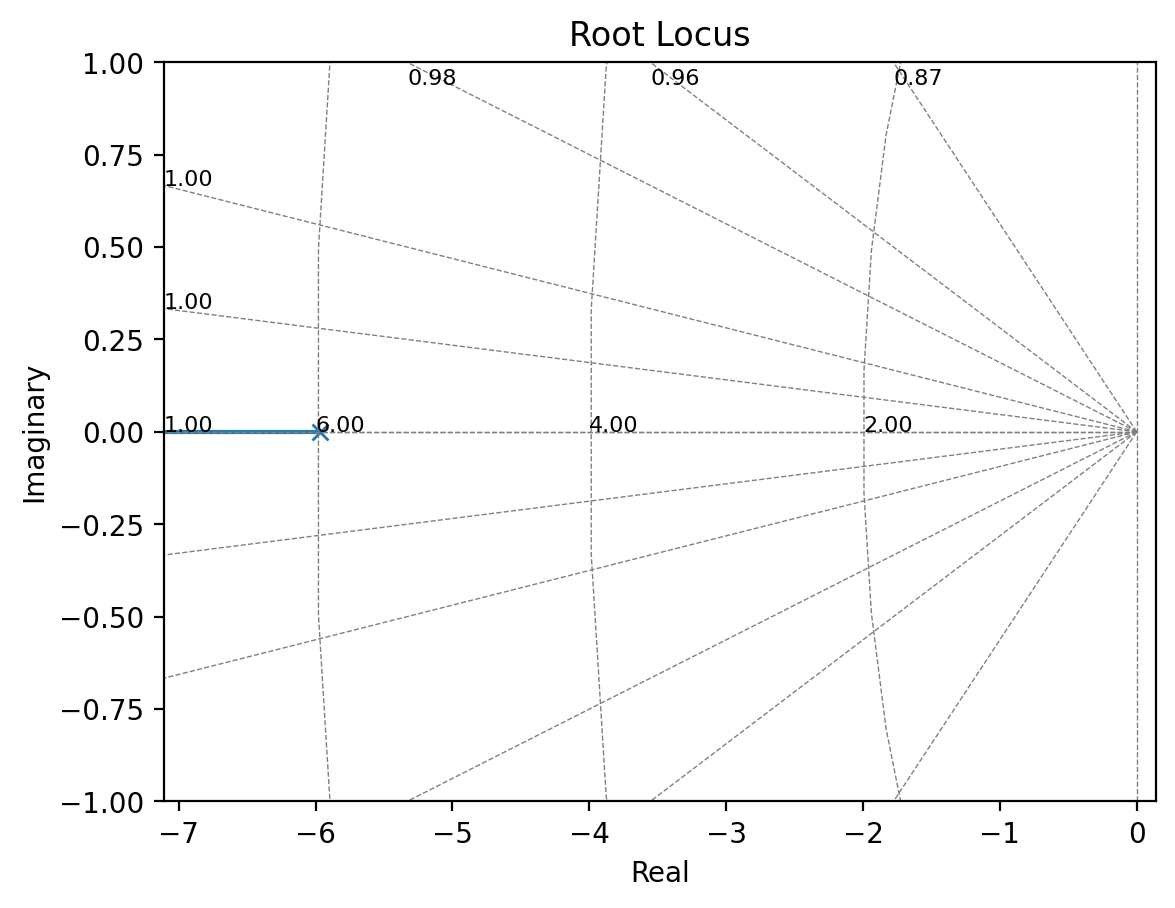

In [11]:
ct.root_locus(Gs, plot=True);


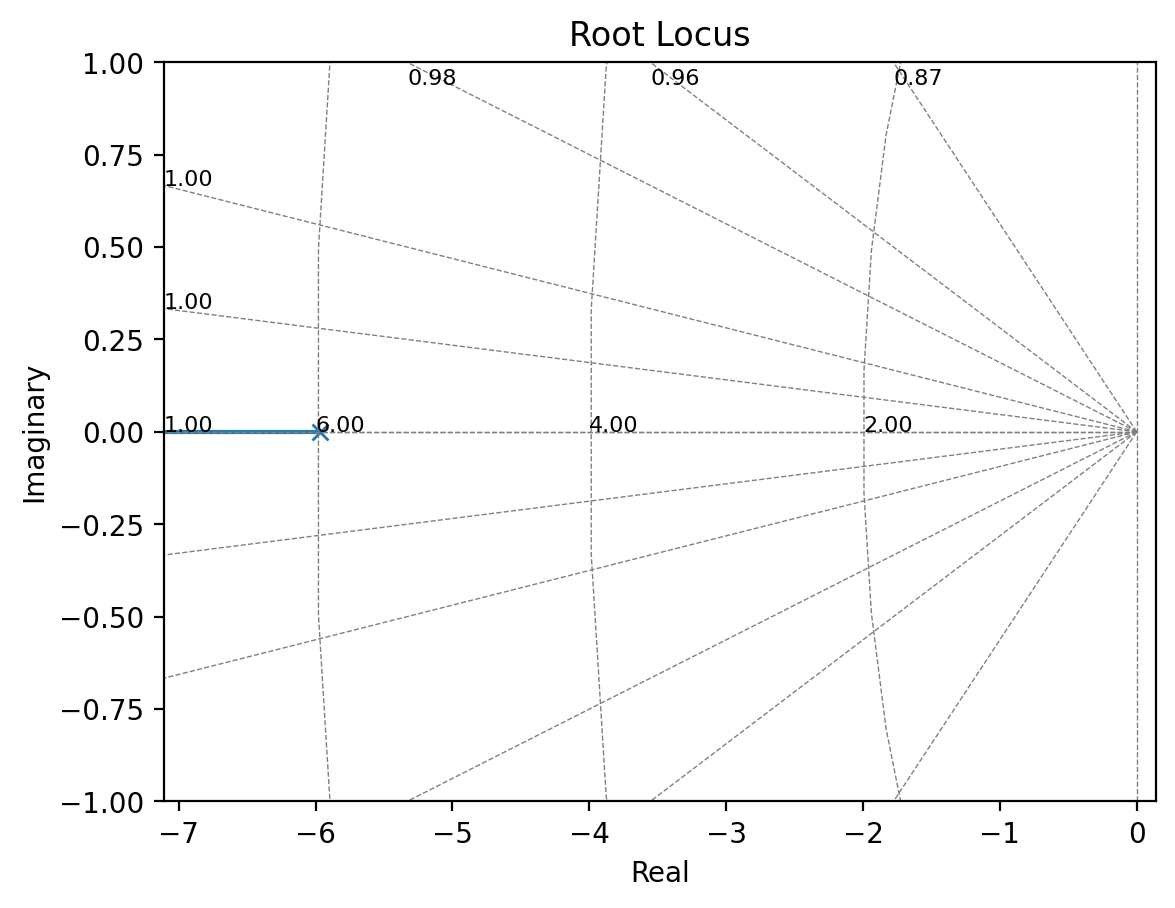

In [12]:
Kp = 15/7
Gc = Kp
ct.root_locus(Gc*Gs, plot=True);

---

# **Projeto do Controlador PI**

Função de Transferência de malha aberta:

$$ G(s) = \frac{K_m}{\tau s + 1} = \frac{K  b}{s + b} \tag{A}$$


Em que, 
$K = K_m$ e 
$b = \frac{1}{\tau}$

Função de Transferência de Controlador PI:

$$ G_c (s) = \frac{K_c (s + a)}{s} \tag{B}$$


Em malha fechada:

$$ H(s) = \frac{G_c(s) G(s)}{1 + G_c(s) G(s)} $$

Com o controlador PI na malha, o tipo do sistema passa a ser Tipo 1 (erro em regime permanente nulo para entrada degrau). 


$$ \frac{\omega_n^2}{s^2 + 2 \zeta \omega_n s + \omega_n^2 } $$





Ganho do Controlador PI: 
 7.250450354985696 
 Zero do PI: 
 -12.24012568964887


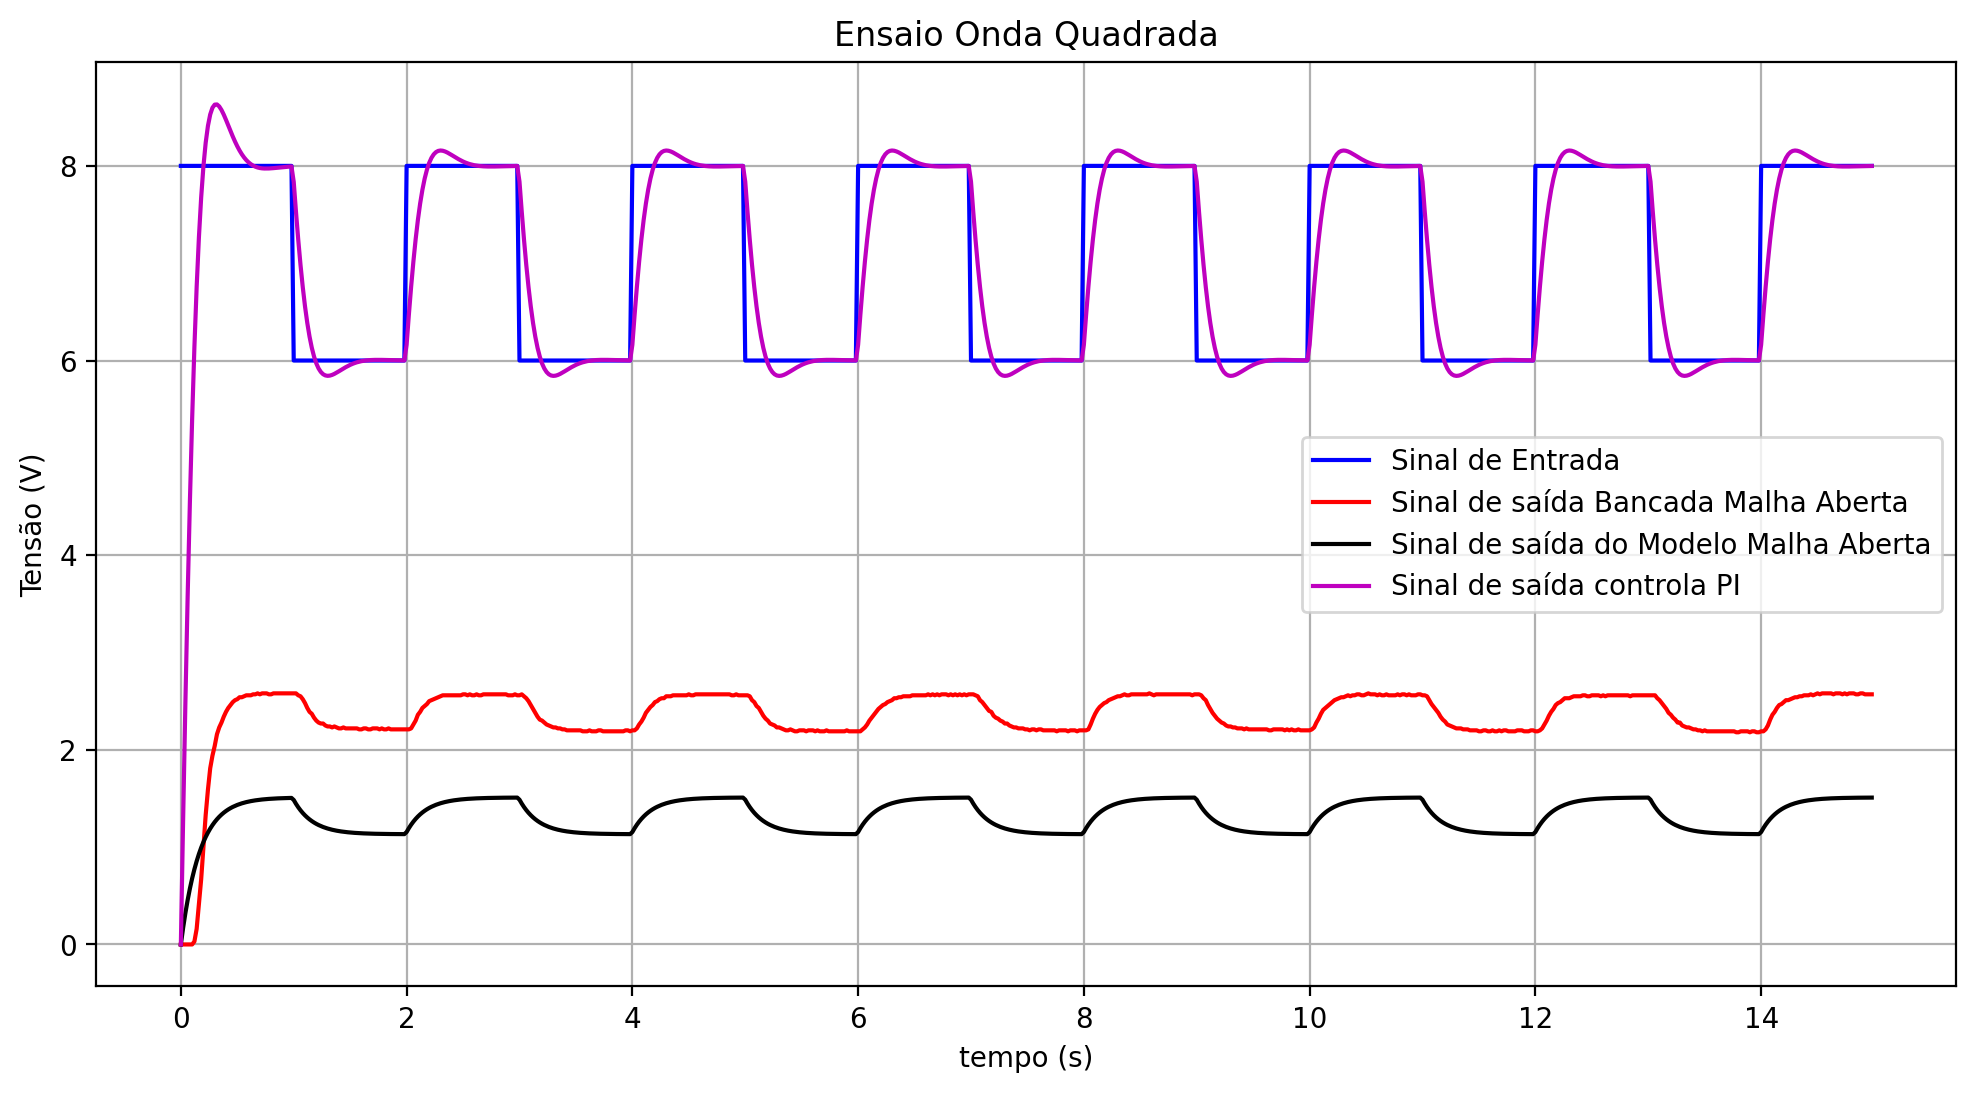

In [13]:
# Fator de Amortecimento
qsi = 0.707
# Freq Natural
wn = 10

b = 1/tau
K = km

Kc = (((2*qsi*wn)/b)-1)/K
a = - (wn**2)/(Kc*K*b)

print('\nGanho do Controlador PI: \n', Kc, '\n Zero do PI: \n', a)

# Controlador Propocional Integral
Gc = ct.tf([Kc*1, -Kc*a], [1, 0])

# Sistema em Malha Fechada - com Controlador Proporcional Integral
H_pi = ct.feedback(Gc*Gs, 1, sign = -1)

# Sinal de Controle
C_pi = ct.feedback(Gc, Gs, sign = -1)

_, ymf_pi = ct.forced_response(H_pi, T = tempo, U = sinal_entrada)
_, u_pi = ct.forced_response(C_pi, T = tempo, U = sinal_entrada)

# Plotagem dos gráficos dos sinais de entrada e saída sem nível DC
plt.figure(figsize=(12, 6))
plt.plot(tempo, sinal_entrada, c = 'b', label = "Sinal de Entrada")
plt.plot(tempo, sinal_saida, 'r', label = "Sinal de saída Bancada Malha Aberta")
plt.plot(tempo, saida_modelo_com_dc, 'k', label = "Sinal de saída do Modelo Malha Aberta")
plt.plot(tempo, ymf_pi, "m", label = "Sinal de saída controla PI")

plt. title('Ensaio Onda Quadrada')
plt.ylabel('Tensão (V)')
plt.xlabel('tempo (s)')
plt.legend()
plt.grid()
plt.show()

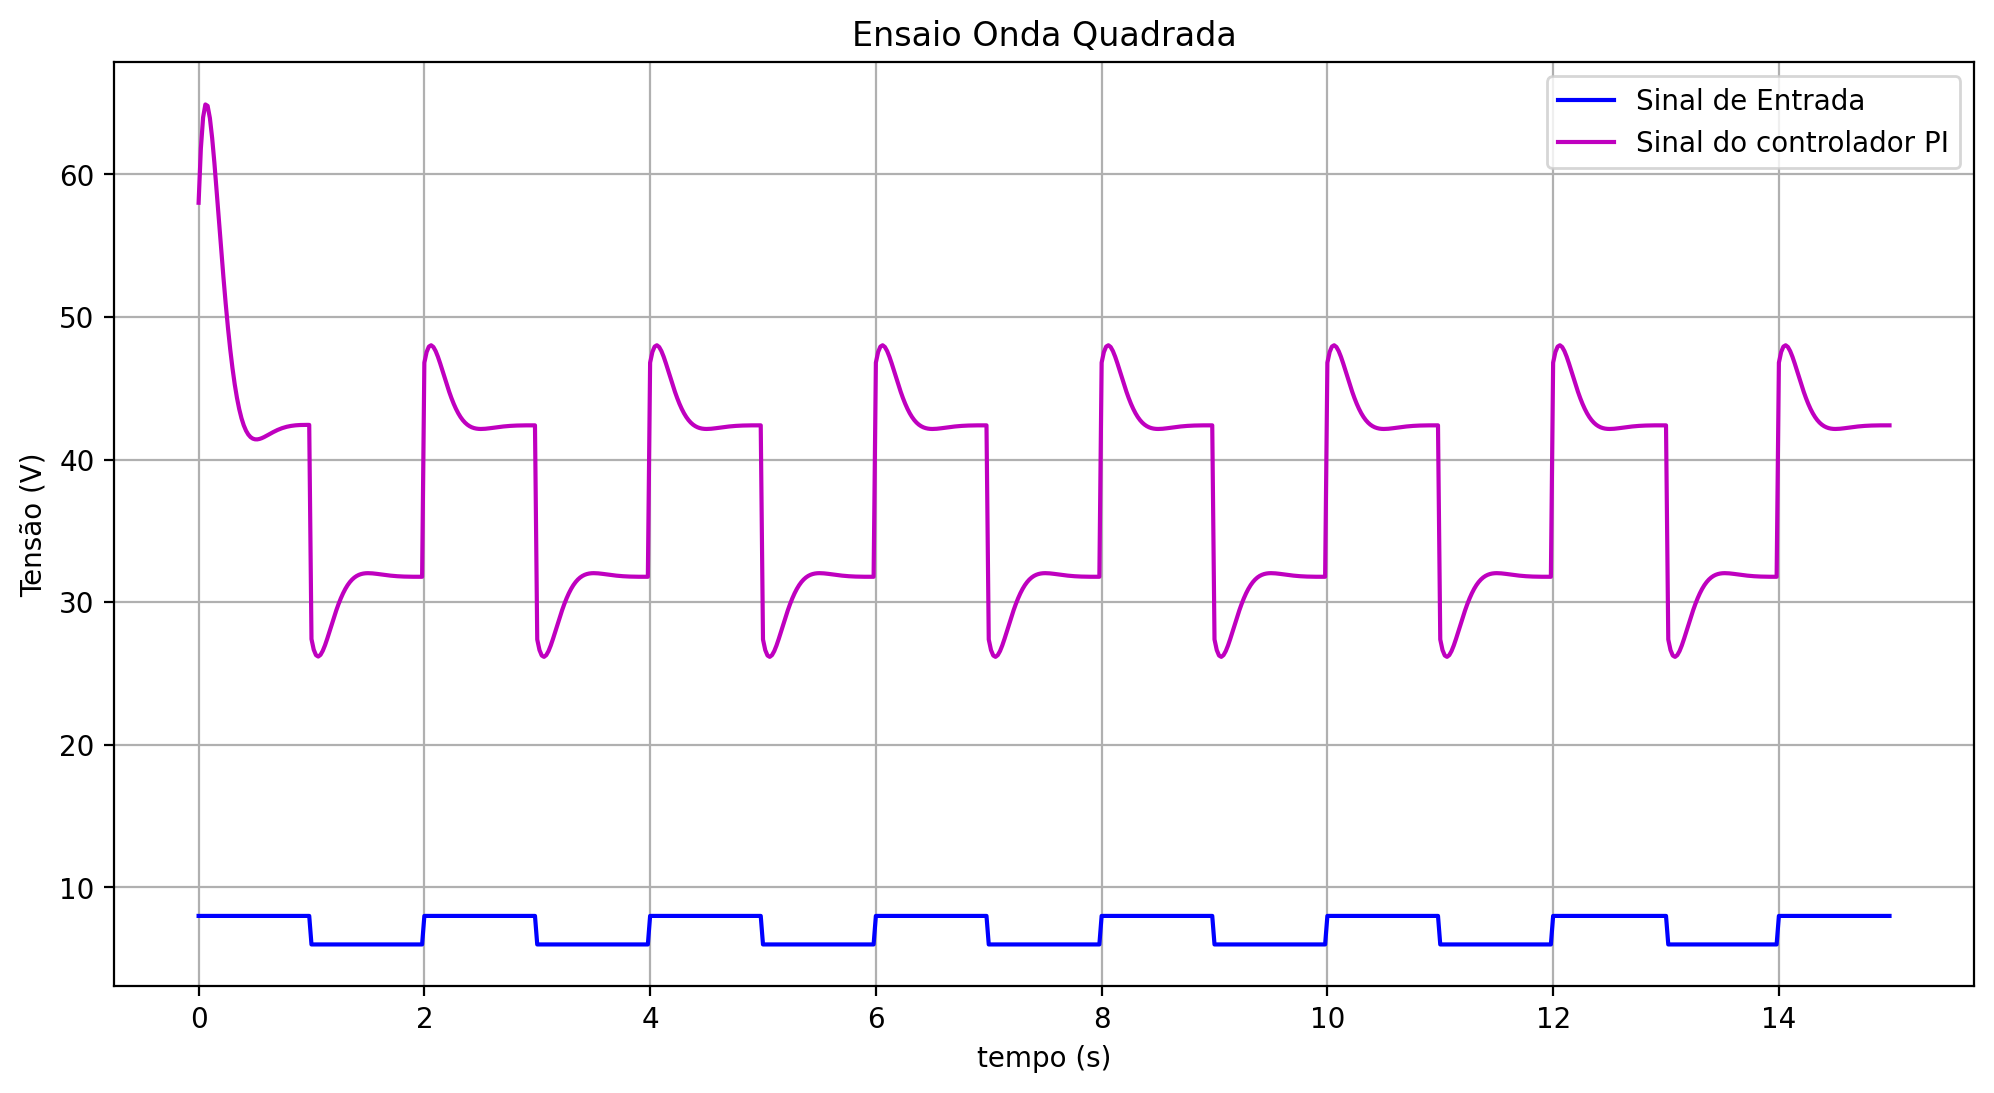

In [14]:
# Plotagem dos gráficos dos sinais de entrada e saída sem nível DC
plt.figure(figsize=(12, 6))
plt.plot(tempo, sinal_entrada, c = 'b', label = "Sinal de Entrada")
plt.plot(tempo, u_pi, "m", label = "Sinal do controlador PI")

plt. title('Ensaio Onda Quadrada')
plt.ylabel('Tensão (V)')
plt.xlabel('tempo (s)')
plt.legend()
plt.grid()

Polos de MF: 
 [-5.97014925+0.j]


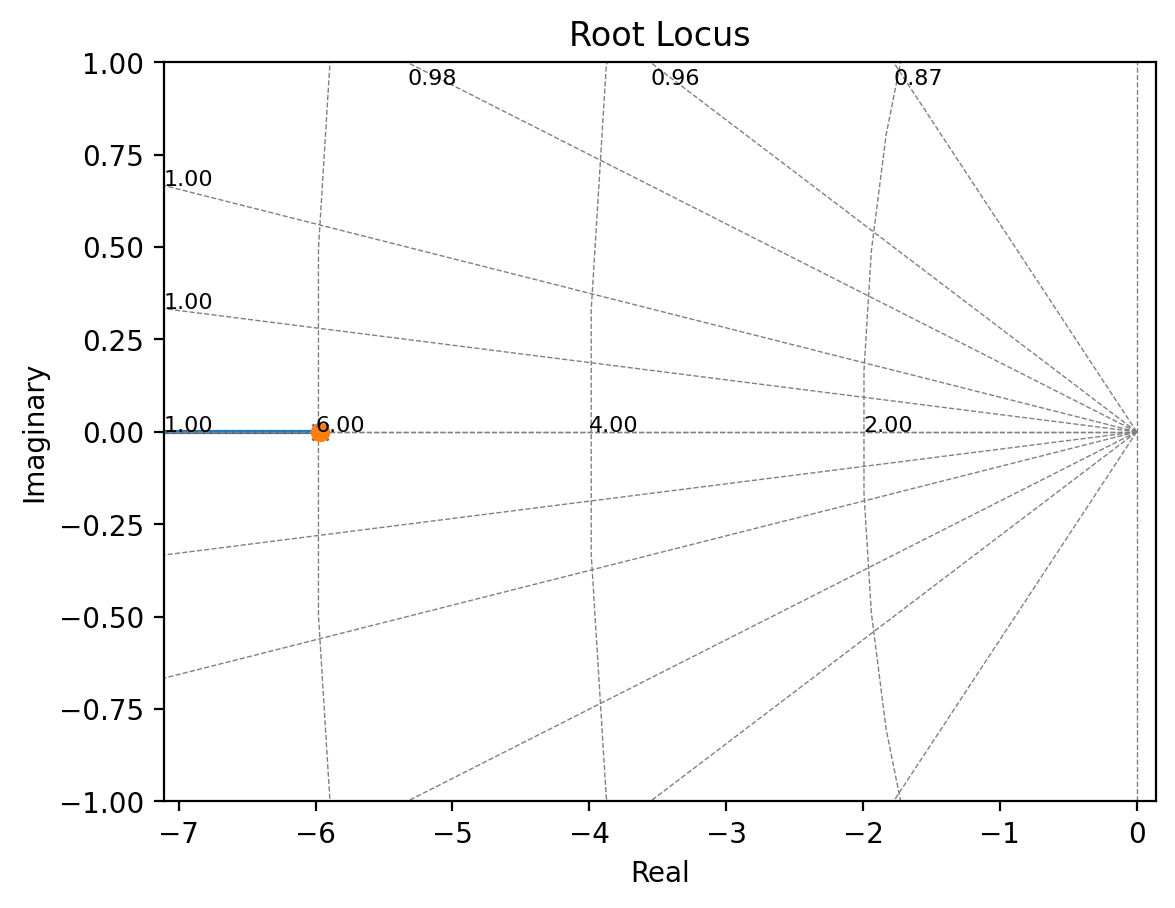

In [15]:
ct.rlocus(Gs, plot=True, grid = True);
print('Polos de MF: \n', Gs.pole() )
plt.plot(np.real(Gs.pole()),np.imag(Gs.pole()),'o')
plt.show()

Polos de MF: 
 [-7.07+7.07213546j -7.07-7.07213546j]


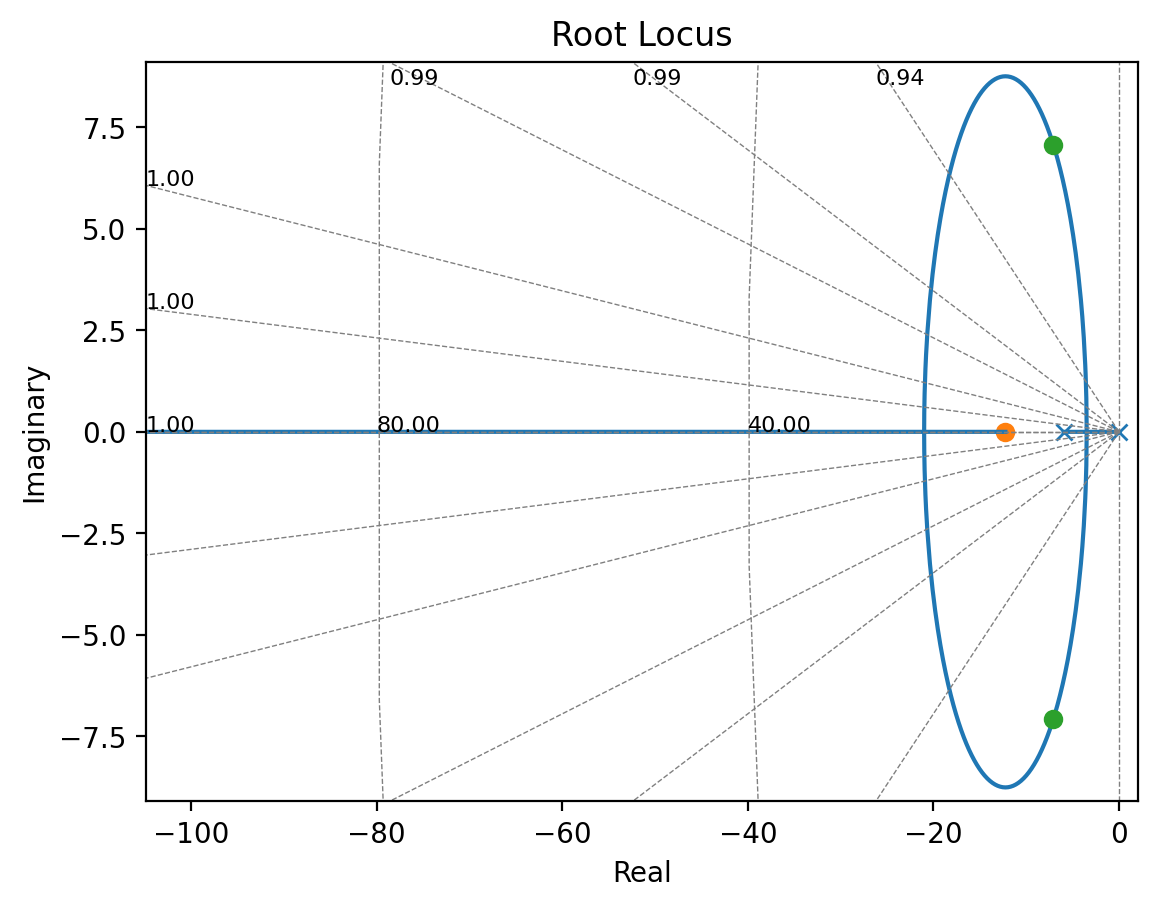

Freq Natural: 
 [10. 10.]
Fator de Amortecimento: 
 [0.707 0.707]


In [16]:
ct.rlocus(Gc*Gs, plot=True, grid = True);
print('Polos de MF: \n', H_pi.pole() )
plt.plot(np.real(H_pi.pole()),np.imag(H_pi.pole()),'o')
plt.show()

print('Freq Natural: \n', np.abs(H_pi.pole()))
print('Fator de Amortecimento: \n', np.cos(np.pi - np.angle(H_pi.pole())))

In [17]:
Ts = 0.02
Gz = ct.c2d(Gc, Ts, 'tustin')
print('Função de Transferência Discreta: \n', Gz)

Função de Transferência Discreta: 
 
8.138 z - 6.363
---------------
     z - 1

dt = 0.02



## Implementação do Controlador PI

$$\frac{U(z)}{E(z)} = \frac{b_0 z + b_1}{z - 1} \frac{z^{-1}}{z^{-1}} $$


Equação de Diferenças:

$$ u(k) = u(k-1) + b_0 e(k) + b_1 e(k-1)$$

$$ u(k) = u(k-1) + 8.138 e(k) - 6,363e(k-1)$$



$$ $$

In [19]:
uk = 0.0
uk1 = 0.0
ek = 0.0
ek1 = 0.0
y = 0.0  # Sinal de Saída
k = 0.0
ref = 7.0  # Sinal de Referência
T = 0.02
Tm = 1000*T

while k < 20:
    ek = ref - y
    # Equação de diferenças implementada
    uk = uk1 + 8.138*ek - 6.363*ek1
    print(uk)

    ek1 = ek
    uk1 = uk
    k = k + 1




56.966
69.39099999999999
81.816
94.24100000000001
106.66600000000003
119.09100000000004
131.51600000000005
143.94100000000006
156.36600000000007
168.79100000000008
181.2160000000001
193.6410000000001
206.06600000000012
218.4910000000001
230.9160000000001
243.34100000000012
255.76600000000013
268.19100000000014
280.61600000000016
293.04100000000017
